# Signal Processing

In this notebook we will explore methods for extracing signals from data.  This incldes computing correlation functions to tease out signals; convolution of data to model the impact of poin spread fuctions (beams in  and for use as a filter; the use of the fourier transform for filtering and for signal extraction.

### Correlation Functions
    
The correlation fuction is defined as
$$C(x)=⟨𝑓(𝑥′+𝑥)𝑔(𝑥′)⟩\tag{11}$$

which is actually the covariance from the previous notebook where $(x'+x) \rightarrow y$ and where the lag from $x'$ equals $x$.
 
Correlation functions are a way to measure the degree of similarity between a series and a lagged version of that same series, or even a another series. The former is an autocorrelation function, the latter is a cross-correlation.

<b> Warning: </b> for reasons I do not understand, many computational libraries conflate covariance and correlation. For instance, scipy.signal.correlate is equation 11. In order to meet the definition of correlation (at least [Pearson's definition of correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which ranges from -1 to 1), one needs to be careful on what to provide as input to scipy.signal.correlate. See our example below.




  
Autocorrelation (also called serial correlation) is: 
- the correlation of a function with itself but with a varying lag. 
- can be calculated by the Pearson’s correlation coefficient. 
- uses the same series twice - once in it’s original form and once in it’s lagged form.




### Example

We will compute the correlations between two datasets. For example if <b>X</b> and <b>Y</b> are two arrays of data, the possible correlation coefficients which could be calcukated are $r_{XX}, r_{XY}, r_{YX}, r_{YY}$. Of course $r_{XX}$ and $r_{YY}$ are auto-correlations while $r_{XY}$ = $r_{YX}$ are cross-correlations.

We obtain tempoerature [data](https://www.wunderground.com) for a couple of months. We weill create arrays of daily temperatures which have a specified lag to them (i.e., one-day lag is x1=day 1-10; y1=day 2-11; two-day lag is y2=day 3-13....ten-day lag is x10=day 10-20; y10=day 20-30. We will apply numpy's "roll" function to make the task of creating lag vectors a bit easier. We can compare the results.

In [230]:
## read in the necessary libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Get data arrays, and also generate random arrays with the same size and same variance.  The random arrays will be used as a refernce for the interpretation of the correlation of the data.

In [231]:
## set up arrays containing the data we will correlate

#Ann Arbor December 2021 temperature data from https://www.wunderground.com, first 29 days only
dec_avg = np.array([37.0,46.1,34.9,36.6,37.4,36.9,23.1,27.8,32.1,44.4,46.2,37.7,39.3,38.8,49.1,54.5,36.4,33.2,29.7,33.5,32.0,26.8,32.4,43.0,46.5,33.9,35.7,33.2,33.6])
aug_avg = np.array([68.1,67.9,70.7,71.9,73.5,74.8,74.7,77.5,76.0,79.4,76.1,74.0,77.0,70.1,68.4,67.8,70.8,74.9,76.7,77.6,76.8,80.4,77.3,78.4,78.3,81.3,78.3,80.9,79.3])
#The day of the month 
day = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])


## for reference, we will also create two random arrays so we can test if the signals we see are statistically signifcant
#Let's define a purely random series of tempersatures that has the same mean and spread of the data.
random1_avg = np.random.normal(np.mean(dec_avg), np.std(dec_avg), size = len(dec_avg))
random2_avg = np.random.normal(np.mean(aug_avg), np.std(aug_avg), size = len(aug_avg))



In [232]:
## A home grown correlation function

def Homegrown_correlation(data,end,roll):
    ## make arrays store the lags consisdered and an array of the correlations-- before averaging 
    lag = np.arange(0,end,1)
    temp = np.zeros((end,end))  ## 2d array conaining all the prodcts between data and itself with lags
    for j in range(end):
        for i in range (end):
            if (roll):  ## compute the data times its lagged self, using on np.roll
                avg_day = data
                avg_lag = np.roll(data,i)      
            else:      ## compute the data times its lagged self, using on array indexing-- this is the same as roll
                avg_day = data[j:j+end]
                avg_lag = data[j+i:j+i+end]
            ## store the correlation coeffcient
            temp[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]
            # or we could use r_xy = (np.mean((avg_day - np.mean(avg_day))*(avg_lag - np.mean(avg_lag))))/(np.sqrt(np.var(avg_day)*np.var(avg_lag)))    
    correlation = np.mean(temp,axis=0)  ## do the averaging
    return(lag,correlation)

## some setup variables-- the fuciton has two options, rol 

#Define max lag time (be careful with edges, maybe don't go beyond vector length*3) 

#We have two choices, NUMPYs "roll" or our own defined lag.
#Keep in mind that our max lag is 9 days (min lag is 0 days) unless we "roll over" the data
roll = True
if (roll):
    end = 29
else:
    end = 10
    
    

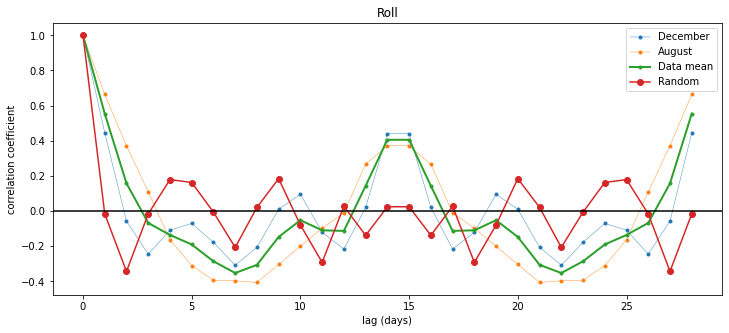

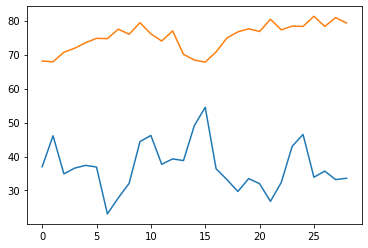

In [233]:
## compute the correlations 
lag,dec_corr = Homegrown_correlation(dec_avg,end,roll)
lag,aug_corr = Homegrown_correlation(aug_avg,end,roll)
lag,random1_corr = Homegrown_correlation(random1_avg,end,roll)
lag,random2_corr = Homegrown_correlation(random2_avg,end,roll)


## average the data correlations and the random correlations together.
data_corr_avg = (dec_corr + aug_corr)/2
random_corr_avg= (random1_corr + random2_corr)/2.0


#############################

## now make a plot
#Now, make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  

ax1.plot(lag,dec_corr,'.-',linewidth=0.4, label='December')
ax1.plot(lag,aug_corr ,'.-',linewidth=0.4,label='August')
ax1.plot(lag,data_corr_avg ,'.-',linewidth=2,label='Data mean')

ax1.plot(lag,random_corr_avg,'o-',label='Random')
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
if (roll):
    ax1.set_title('Roll')
else:
    ax1.set_title('Lag vectors')
plt.show()


plt.plot(dec_avg)
plt.plot(aug_avg)


### discuss: 
    What's happening at t=14 or t =15 days or t=30 days?
    

## alternative implementation

We will use scipy.signal library and the correlate function. We also need the lags given by correlation_lags (instead of calculating our own). <b> The function signal.correlation_lags is only available in scipy 1.6+</b>

<b>NOTE:</b> scipy.signal.correlate does not naturally return the equivalent of the Pearson correlation (see above). In order to do so, one must use the centered data and also normalize the input to the standard deviation.


1.7.1


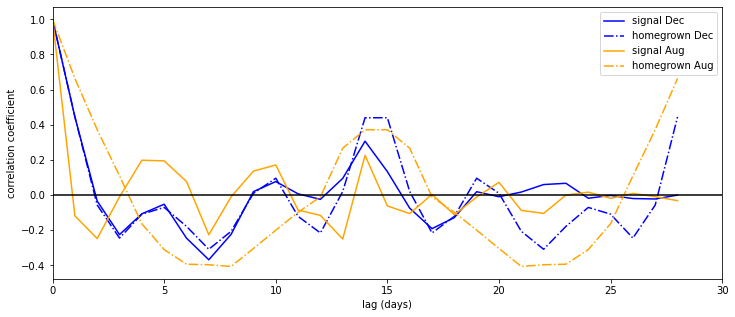

In [234]:
##You must have version scipy.signal >=1.7 to use correlation_lags
import scipy
print(scipy.__version__)
import scipy.signal as signal

dec_corr2 = signal.correlate((dec_avg - np.mean(dec_avg))/np.std(dec_avg),(dec_avg - np.mean(dec_avg))/np.std(dec_avg),mode='full',method='direct')/len(dec_avg)
dec_lag2 = signal.correlation_lags(dec_avg.size,dec_avg.size,mode='full')
aug_corr2 = signal.correlate((aug_avg - np.mean(aug_avg))/np.std(aug_avg),(aug_avg - np.mean(aug_avg))/np.std(aug_avg),mode='full',method='direct')/len(aug_avg)
aug_corr2 = signal.correlate((random1_avg - np.mean(random1_avg))/np.std(random1_avg),(random1_avg - np.mean(random1_avg))/np.std(random1_avg),mode='full',method='direct')/len(aug_avg)


aug_lag2 = signal.correlation_lags(aug_avg.size,aug_avg.size,mode='full')

#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,dec_corr,'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,aug_corr,'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.set_xlim(0,30)#NOTE THE LIMIT OF 0. What happens if I DROP THIS?
ax1.legend()
plt.show()

Note that both calculates are close to each other, but not identical. When in doubt and when you want a correlation coefficient (function), use np.corrcoef.

While it does make things less cumbersome, you still need to be careful about your interpretation of the resultes.

For instance, I plotted only for lags >0. If you remove that, you will see the mirror image appear:

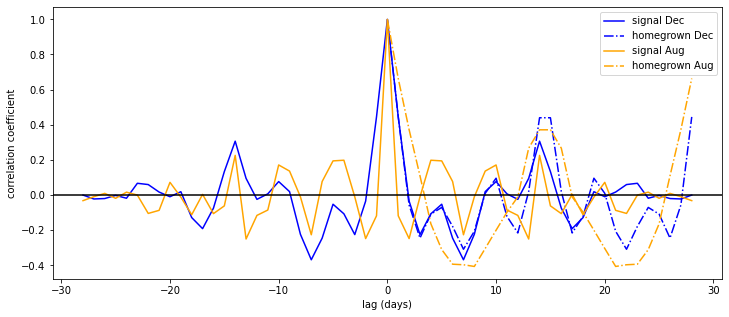

In [235]:
#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,dec_corr,'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,aug_corr,'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
plt.show()

####  Some lessons
    - Covariance and correlation are often confusing conflated in the literature
    - for instance, if the data have unit variance (i.e. a scaled Gaussian), correlation is exactly covariance
    - sometimes texts/authors will assume the variance can just be scaled out and write their theory accordingly
    - you don't always know that or understand the consequences of a throw-away comment in their text
    - Calculating covariance is straightforward, but occasionally there can be numerical issues (see Wikipedia for examples)
    - There is no "right" way to calculate correlation (see above where we tried 3(!) techniques) and they do not always agree. 
    - The 2-pt spatial correlation function is calculated through "pair counting" within spheres of radius $R$ --the lag. Counts are made in the data and compared to randomly distributed points. This looks NOTHING like the tools we have used above which are common in 1D signal processing.
    - The coin example is another case where we have "made up" our measure of correlaton.
 
   
#### Final thought on Correlation
    
When discussing signal processing, you will often see correlation expressed as a continuous integral:

$$(f \otimes g)(\tau) = \int_{-\infty}^\infty f^*(t) g(t + \tau) dt  \tag{12}$$

where $f$ and $g$ are signals at given times $t$ with some lag $\tau$. If the signal is light (or anything that could be represented as a complex number), then we require the complex conjugate of $f$ in the integrand (shown as $f^*$.

